In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression

# Neural Networks with PyTorch

[PyTorch](https://pytorch.org) is a machine learning library, most often used for training neural networks via backpropagation. It is, however, a general purpose computing library with support for hardware accelerators like the GPUs. Installing should be as simple running the following command in your virtual environment.

```bash
> pip install torch
```

## PyTorch Tensors

The key unit of computation in PyTorch is the `Tensor` object. In many ways, it will feel similar to `NumPy` arrays. Below are a few examples of simple operations, including converting an `np.array` into `torch.Tensor`. 

In [2]:
x = torch.from_numpy(np.random.randn(5,3)).float()  ## or could use .double() for 64-bit precision
print(x.shape)
print(x.dtype)
print(x.device)
x

torch.Size([5, 3])
torch.float32
cpu


tensor([[-0.2324,  1.2987, -1.8618],
        [-0.4156,  0.2952, -0.7641],
        [ 0.6832, -1.1878, -0.4806],
        [-0.1505,  0.2715,  0.7119],
        [-0.7429,  0.3458, -0.5946]])

As a first difference, we now have an additional `.device` attribute which defines where the tensor is stored and operated on. `cpu` tells us that the tensor will be stored on the usual on-device memory (RAM).

All the usual indexing rules seen with `numpy` generally apply.

In [3]:
## Usual indexing applies.
print(x[0])
print(x[:2, :2])

tensor([-0.2324,  1.2987, -1.8618])
tensor([[-0.2324,  1.2987],
        [-0.4156,  0.2952]])


PyTorch also has all the expected utility functions to create tensors. All the typical unary/binary operations, and familiar broadcasting rules from `numpy` apply here directly.

In [4]:
y = torch.randn_like(x)  ## Equivalent to torch.randn(*x.shape).float()
x * y

tensor([[-0.1342, -1.6415,  2.6914],
        [ 0.2252, -0.1147, -0.2387],
        [-0.8594, -1.7302, -0.7838],
        [ 0.0148,  0.0842,  2.4011],
        [ 0.4283,  0.5355,  0.2023]])

`torch.Tensor` API allows chaining of operations (which makes the code more readable). For instance consider here the matrix multiplication between the two tensors $X \in \mathbb{R}^{5\times 3}$ and $Y \in \mathbb{R}^{5\times 3}$, as $Z = X^TY \in \mathbb{R}^{3\times 3}$.

In [5]:
z = x.transpose(1, 0).matmul(y)  ## Equivalent to torch.matmul(x.transpose(1, 0), y)
print(z.shape)

## We can also go back to NumPy, if needed. Need to make sure the tensor is on CPU before the conversion.
print(z.cpu().numpy())

z

torch.Size([3, 3])
[[-0.3252213   0.25349212  1.0656229 ]
 [ 1.8578745  -2.8667784  -2.9241724 ]
 [ 0.21615224  1.2501521   4.272257  ]]


tensor([[-0.3252,  0.2535,  1.0656],
        [ 1.8579, -2.8668, -2.9242],
        [ 0.2162,  1.2502,  4.2723]])

## Automatic Differentiation

Automatic Differentiation (AD) is the key workhorse of training modern neural networks. In essense, it is simply an efficient implementation of the chain rule from calculus on an abstraction called the _computational graph_. PyTorch does automatic differentiation through its `autograd` module on top of computational graphs that are built dynamically (i.e. at runtime).

For instance, consider the function

$$
f_\mathbf{w}(\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x})
$$

where $\sigma$ is the sigmoid function. We will compute its derivative with respect to $\mathbf{w}$ using automatic differentiation in PyTorch.

$$
\frac{d}{d \mathbf{w}}f_\mathbf{w}(\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x})\cdot(1-\sigma(\mathbf{w}^T\mathbf{x}))\cdot\mathbf{x}
$$

The key method of note will be `.requires_grad_()`. This sets the tensor up to store gradients during "backpropagation". In practice, we often don't need gradients for all tensors in the computational graph and 
flagging some of those tensors to not store gradients can save a lot of memory consumption.

In [6]:
## Assign random 2-D values to both tensors, and make w differentiable

w = (2. * torch.randn(2)).float().requires_grad_(True)
x = (2. * torch.randn(2)).float().requires_grad_(False)
f = w.dot(x).sigmoid()
f

tensor(0.5909, grad_fn=<SigmoidBackward>)

Computing backpropagation for most use-cases amounts to calling `.backward()` on the resulting tensor.

**Warning**: Running the next cell twice will throw an error because the computational graph is destroyed once the gradients have been computed (more precisely vector-Jacobian products). We can keep the graph around, if we do need it (e.g. for higher-order gradients). For now, to re-run the backward call, first re-run the previous cell that creates `f`.

In [7]:
f.backward()

In [8]:
auto_grad_w = w.grad
with torch.no_grad():
    analytic_grad_w = f * (1 - f) * x

torch.allclose(auto_grad_w, analytic_grad_w)

True

We see that the analytic and the automatically computed gradient are the same. In fact, automatic differentiation computes _exact_ gradients for complex functions, by simply building on top of the derivatives for primitive functions like addition, multiplication, logarithms etc.

This abstraction is powerful because now we don't need to worry about computing derivatives by hand for large and complex functions like those induced by neural networks.

## Linear Regression

Neural networks are general parametric function approximators. Any parametric function can therefore be described as a neural network. Therefore, unsurprisingly, we have been using a neural network all along when we were working with linear regression. This is a neural network with no hidden layers (the input directly connects to the output). As a reminder, linear regression constructs the function

$$
f_{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^T\mathbf{x}
$$

where we assume $\mathbf{w}$ also contains the bias term (with appropriate augmentation for the input $\mathbf{x}$).

In PyTorch, we build neural networks using the `nn.Module` abstraction. The `nn` module has plenty of objects that are equivalent to layers in neural networks. A first linear regression module is below.

In [9]:
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self, in_size):
        super().__init__()

        ## We assume scalar-valued regression, i.e. output size is always 1
        self.fc = nn.Linear(in_size, 1)

    def forward(self, x):
        out = self.fc(x)
        return out

By default parameters are randomly initialized in these modules and can be accessed via the `.parameters()` generator. By default, all `nn.Parameter` containers have `requires_grad` set as `True`.

In [10]:
net = LinearRegression(in_size=2)
for p in net.parameters():
    print(p.shape, p, p.requires_grad)

torch.Size([1, 2]) Parameter containing:
tensor([[-0.3087, -0.2004]], requires_grad=True) True
torch.Size([1]) Parameter containing:
tensor([0.3624], requires_grad=True) True


### Batching

A key feature of tensor libraries like PyTorch is that we can leverage parallelized computations. This means that all neural network modules can take multiple inputs, instead of just a single one. We specify multiple inputs across the "batch dimensions". This will be most clear with the following examples.

In [11]:
x = torch.randn(100, 2)
net(x).shape

torch.Size([100, 1])

In [12]:
x = torch.randn(20, 30, 100, 2)
net(x).shape

torch.Size([20, 30, 100, 1])

Notably, all dimensions are consumed starting from the right to the left. In this case, since `in_size=2`, and the module contains a `nn.Linear` layer, the last dimension is consumed for the matrix multiplication of batched inputs with the parameter vector. All the remaining dimensions of the input are considered as _batch dimensions_. Of course, while this behavior is true for all code PyTorch layers, care must be taken when implementing custom layers to handle batch dimensions. We will see an application of batching later.

In [13]:
## A dummy regression dataset

with torch.no_grad():
    train_x = 5. * torch.randn(100, 2)
    real_w = torch.randn(2, 1)
    real_b = 2.0
    y = train_x.matmul(real_w) + real_b
    train_y = y + torch.randn_like(y)

print(train_x.shape, train_y.shape)

real_w, real_b

torch.Size([100, 2]) torch.Size([100, 1])


(tensor([[-1.0193],
         [ 1.4707]]),
 2.0)

### Key Ingredients of training

Training neural networks with PyTorch involves a few key ingredients:

- Getting the data
- Defining the neural network
- Picking an optimizer (e.g. Stochastic Gradient Descent, SGD)
- Picking an objective function (PyTorch optimizers always minimize, so the objective function must be a loss value to be minimized)
- Iteratively stepping through the optimizer using the computed gradients


In [14]:
net = LinearRegression(in_size=train_x.size(-1))
optim = torch.optim.SGD(net.parameters(), lr=1e-2)
ell = nn.MSELoss()
epochs = 500

loss_trace = []
for e in range(epochs):
    optim.zero_grad()  ## We must clear the gradient accumulators from previous runs

    pred_y = net(train_x)
    loss = ell(pred_y, train_y)

    loss_trace.append(loss.detach().item())
    if (e + 1) % 50 == 0:
        print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')

    loss.backward()
    optim.step()

for p in net.parameters():
    print(p)

[Epoch 50] Loss: 1.3682911396026611
[Epoch 100] Loss: 1.2086037397384644
[Epoch 150] Loss: 1.1872906684875488
[Epoch 200] Loss: 1.184446096420288
[Epoch 250] Loss: 1.1840662956237793
[Epoch 300] Loss: 1.1840157508850098
[Epoch 350] Loss: 1.1840089559555054
[Epoch 400] Loss: 1.184008002281189
[Epoch 450] Loss: 1.1840078830718994
[Epoch 500] Loss: 1.184008002281189
Parameter containing:
tensor([[-0.9859,  1.4691]], requires_grad=True)
Parameter containing:
tensor([1.7763], requires_grad=True)


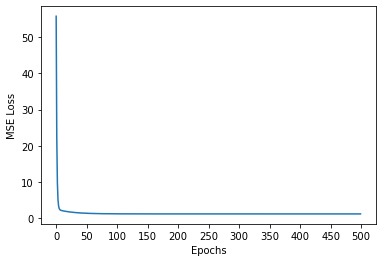

In [15]:
fig, ax = plt.subplots()
ax.plot(range(len(loss_trace)), loss_trace)
ax.set_xticks(range(0, 501, 50))
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss');

A typical successful training schedule will look like this. Such a graph is an indication that our objective has converged to at least a local minima (global if the objective is convex). Note, however, that this may not be sufficient but is a good first diagnostic.

## Logistic Regression

In our new unified view through neural networks, logistic regression is nothing but adding a new sigmoid layer on top of the linear layer. The module below is literally a copy of the previously written `LinearRegression` module, but with the added sigmoid non-linearity through the `nn.Sigmoid()` module.

A new module to notice is `nn.Sequential()`. This allows grouping of different modules that need to be applied in sequence, such that we can avoid boilerplate code which computes each layer one-by-one.

In [16]:
class LogisticRegression(nn.Module):
    def __init__(self, in_size):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.fc(x)
        return out

### Generate Classification Data

We will generate the Two Moons dataset using `scikit-learn`, and make sure we convert them to `torch.Tensor` for subsequent training with PyTorch.


In [17]:
from sklearn import datasets

train_x, train_y = datasets.make_moons(200, noise=0.1)
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).int()

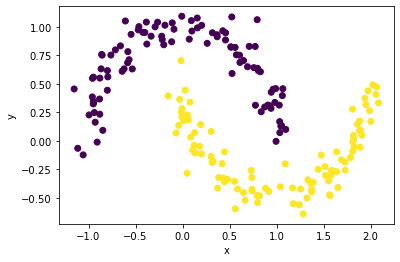

In [18]:
fig, ax = plt.subplots()

ax.scatter(train_x[:, 0], train_x[:, 1], c=train_y)
ax.set_xlabel('x')
ax.set_ylabel('y');

### Training using the Cross-Entropy Loss

In [2]:
net = LogisticRegression(in_size=train_x.size(-1))
optim = torch.optim.SGD(net.parameters(), lr=5e-1)
ell = nn.BCELoss()
epochs = 1000

loss_trace = []
for e in range(epochs):
    optim.zero_grad()  ## We must clear the gradient accumulators from previous runs

    p_y = net(train_x).squeeze(-1)
    loss = ell(p_y, train_y.float())

    loss_trace.append(loss.detach().item())
    if (e + 1) % 50 == 0:
        print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')

    loss.backward()
    optim.step()

NameError: name 'LogisticRegression' is not defined

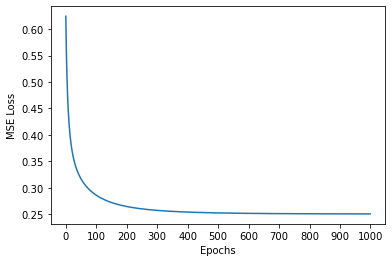

In [20]:
fig, ax = plt.subplots()
ax.plot(range(len(loss_trace)), loss_trace)
ax.set_xticks(range(0, epochs + 1, 100))
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss');

### Plotting the predictive surface

As expected, we will find that logistic regression with linear predictors can only build linear decision boundaries.

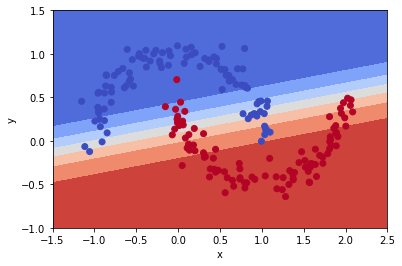

In [21]:
g_x, g_y = torch.meshgrid(torch.linspace(-1.5, 2.5, 100), torch.linspace(-1., 1.5, 100))
mesh_x = torch.cat([g_x.unsqueeze(-1), g_y.unsqueeze(-1)], axis=-1)
with torch.no_grad():
    p_mesh = net(mesh_x)

fig, ax = plt.subplots()
ax.contourf(mesh_x[..., 0], mesh_x[..., 1], p_mesh[..., 0], cmap=plt.cm.coolwarm)
ax.scatter(train_x[:, 0], train_x[:, 1], c=train_y, cmap=plt.cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y');

## Logistic Regression with a non-linear neural network

Neural networks are powerful in general because they allow non-linearities through _activation functions_. We use the `nn.ReLU()` activation function below, which is applied pointwise as

$$
ReLU(x) = \begin{cases}x, \text{if}~x > 0 \\ 0, \text{otherwise}\end{cases}
$$

Such non-linearities allow us non-linear decision boundaries.


In [23]:
class LogisticRegression(nn.Module):
    def __init__(self, in_size):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_size, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.fc(x)
        return out


### Data Loaders

While not really necessary here, PyTorch Data Loaders provide a useful abstraction to work with large datasets. We first define a PyTorch dataset, and then wrap it in a data loader.

In [24]:
from torch.utils.data import Dataset, DataLoader

class MoonsDataset(Dataset):
    def __init__(self, n=200, noise=0.1):
        super().__init__()
        train_x, train_y = datasets.make_moons(200, noise=noise)

        train_x = torch.from_numpy(train_x).float()
        train_y = torch.from_numpy(train_y).int()

    def __len__(self):
        return train_x.size(0)

    def __getitem__(self, i):
        return train_x[i], train_y[i]

We will now train using the DataLoader which will automatically generate _mini-batches_ of data. Another important change to note here is the introduction of _regularization_ using the `weight_decay` argument.

In [25]:
moons = MoonsDataset()
loader = DataLoader(moons, batch_size=50, shuffle=True)

net = LogisticRegression(in_size=train_x.size(-1))
optim = torch.optim.SGD(net.parameters(), lr=5e-1, weight_decay=1e-2)
ell = nn.BCELoss()
epochs = 1000

loss_trace = []
for e in range(epochs):
    optim.zero_grad()  ## We must clear the gradient accumulators from previous runs

    for b_x, b_y in loader:
        p_y = net(b_x).squeeze(-1)
        loss = ell(p_y, b_y.float())

        loss_trace.append(loss.detach().item())

        loss.backward()
        optim.step()

    if (e + 1) % 100 == 0:
        print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')

[Epoch 100] Loss: 0.06053316220641136
[Epoch 200] Loss: 0.01613636501133442
[Epoch 300] Loss: 0.01552657876163721
[Epoch 400] Loss: 0.019938671961426735
[Epoch 500] Loss: 0.05497756600379944
[Epoch 600] Loss: 0.013077277690172195
[Epoch 700] Loss: 0.04834607243537903
[Epoch 800] Loss: 0.062184639275074005
[Epoch 900] Loss: 0.015480798669159412
[Epoch 1000] Loss: 0.036529697477817535


### A non-linear prediction surface

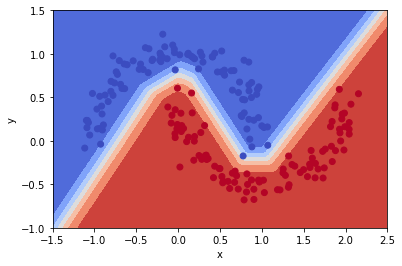

In [30]:
g_x, g_y = torch.meshgrid(torch.linspace(-1.5, 2.5, 100), torch.linspace(-1., 1.5, 100))
mesh_x = torch.cat([g_x.unsqueeze(-1), g_y.unsqueeze(-1)], axis=-1)
with torch.no_grad():
    p_mesh = net(mesh_x)

fig, ax = plt.subplots()
ax.contourf(mesh_x[..., 0], mesh_x[..., 1], p_mesh[..., 0], cmap=plt.cm.coolwarm)
ax.scatter(train_x[:, 0], train_x[:, 1], c=train_y, cmap=plt.cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y');

The predicition surface is non-linear and clearly separates our two classes cleanly!

What would happen if we set `weight_decay` to a higher value? What about a lower value?